<a href="https://colab.research.google.com/github/AbhinavMekala/ML_Hackathon_Team_14/blob/main/Hackman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded 49979 words from corpus.txt
Training Hidden Markov Model (HMM) from corpus...
HMM training complete.
Beginning training phase...
Training reinforcement learning agent...


 14%|█▍        | 275/2000 [00:01<00:12, 132.77it/s]

Evaluation: Success=35.50%, Avg Wrong=4.55, Avg Repeats=0.00
Episode 200: Success=35.50%, Wrong=4.55, Repeats=0.00, Epsilon=0.409


 22%|██▏       | 433/2000 [00:03<00:15, 100.14it/s]

Evaluation: Success=42.00%, Avg Wrong=4.45, Avg Repeats=0.00
Episode 400: Success=42.00%, Wrong=4.45, Repeats=0.00, Epsilon=0.335


 31%|███       | 620/2000 [00:04<00:17, 79.96it/s]

Evaluation: Success=36.00%, Avg Wrong=4.52, Avg Repeats=0.00
Episode 600: Success=36.00%, Wrong=4.52, Repeats=0.00, Epsilon=0.274


 42%|████▏     | 833/2000 [00:07<00:21, 54.74it/s]

Evaluation: Success=33.50%, Avg Wrong=4.61, Avg Repeats=0.00
Episode 800: Success=33.50%, Wrong=4.61, Repeats=0.00, Epsilon=0.225


 54%|█████▍    | 1077/2000 [00:08<00:07, 121.08it/s]

Evaluation: Success=34.50%, Avg Wrong=4.53, Avg Repeats=0.00
Episode 1000: Success=34.50%, Wrong=4.53, Repeats=0.00, Epsilon=0.184


 62%|██████▏   | 1240/2000 [00:10<00:07, 99.36it/s]

Evaluation: Success=35.00%, Avg Wrong=4.54, Avg Repeats=0.00
Episode 1200: Success=35.00%, Wrong=4.54, Repeats=0.00, Epsilon=0.151


 73%|███████▎  | 1452/2000 [00:11<00:04, 114.81it/s]

Evaluation: Success=43.50%, Avg Wrong=4.47, Avg Repeats=0.00
Episode 1400: Success=43.50%, Wrong=4.47, Repeats=0.00, Epsilon=0.123


 83%|████████▎ | 1660/2000 [00:13<00:02, 125.67it/s]

Evaluation: Success=37.00%, Avg Wrong=4.52, Avg Repeats=0.00
Episode 1600: Success=37.00%, Wrong=4.52, Repeats=0.00, Epsilon=0.101


 92%|█████████▏| 1837/2000 [00:14<00:01, 91.12it/s]

Evaluation: Success=35.00%, Avg Wrong=4.51, Avg Repeats=0.00
Episode 1800: Success=35.00%, Wrong=4.51, Repeats=0.00, Epsilon=0.083


100%|██████████| 2000/2000 [00:16<00:00, 124.54it/s]

Evaluation: Success=32.00%, Avg Wrong=4.43, Avg Repeats=0.00
Episode 2000: Success=32.00%, Wrong=4.43, Repeats=0.00, Epsilon=0.068


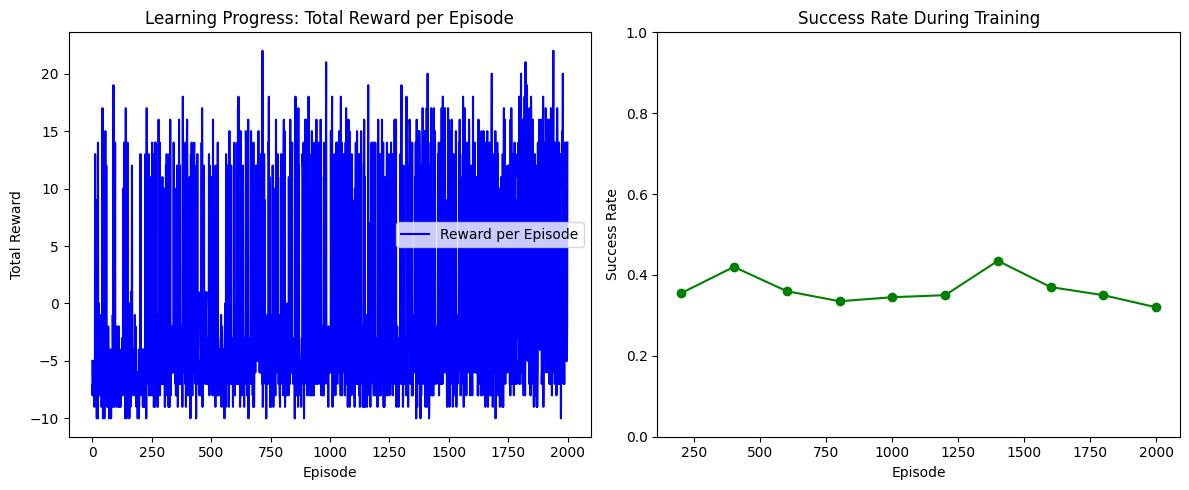

Final Evaluation:
Evaluation: Success=34.50%, Avg Wrong=4.52, Avg Repeats=0.00
Final Success Rate: 34.50%
Average Reward per Episode: -1.17
Average Wrong Guesses: 4.52
Average Repeated Guesses: 0.00


In [1]:
import numpy as np
from tqdm import tqdm
from typing import List, Set, Dict
import os
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# =====================================================
# Hangman RL Agent with Hidden Markov Model (HMM) Integration
# =====================================================

# Define the alphabet and utility mappings
ALPHABET = [chr(ord('a') + i) for i in range(26)]
ALPH_IDX = {c: i for i, c in enumerate(ALPHABET)}

# =====================================================
# Data Loading and Preprocessing
# =====================================================
def clean_word(w: str) -> str | None:
    """
    Clean and preprocess a single word by removing whitespace,
    converting to lowercase, and filtering out non-alphabetic words.
    """
    w = w.strip().lower()
    return w if w.isalpha() else None

def load_word_list(path: str) -> List[str]:
    """
    Load a word list from a text file. Each line should contain one word.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    with open(path, "r", encoding="utf-8") as f:
        words = [clean_word(line) for line in f]
    words = [w for w in words if w]
    print(f"Loaded {len(words)} words from {path}")
    return words

# =====================================================
# Hidden Markov Model (HMM)
# =====================================================
class ProperHMMOracle:
    """
    Trains a probabilistic model (HMM) to capture word structure.
    The model estimates:
      - Start letter probabilities
      - Letter-to-letter bigram transitions
      - Positional letter frequencies (e.g., 'e' often near the end)
      - Emission probabilities given known/masked letters
    """
    def __init__(self, alpha: float = 1.0):
        self.alpha = alpha
        self.num_letters = len(ALPHABET)
        self.trained = False

    def fit(self, word_list: List[str]):
        """
        Train the HMM from a corpus of words by estimating:
          - Start letter frequencies
          - Letter transition probabilities
          - Positional letter distributions
          - Unigram fallback distribution
        """
        print("Training Hidden Markov Model (HMM) from corpus...")
        V = self.num_letters
        self.start_counts = np.ones(V) * self.alpha
        self.trans_counts = np.ones((V, V)) * self.alpha
        self.pos_patterns = defaultdict(lambda: np.ones(V) * self.alpha)

        # Count occurrences from corpus
        for word in word_list:
            if not word:
                continue
            self.start_counts[ALPH_IDX[word[0]]] += 1
            for i in range(len(word) - 1):
                self.trans_counts[ALPH_IDX[word[i]], ALPH_IDX[word[i + 1]]] += 1
            for i, ch in enumerate(word):
                rel_pos = i / max(len(word) - 1, 1)
                pos_key = int(rel_pos * 10)
                self.pos_patterns[pos_key][ALPH_IDX[ch]] += 1

        # Normalize counts into probabilities
        self.start_probs = self.start_counts / self.start_counts.sum()
        self.trans_probs = self.trans_counts / self.trans_counts.sum(axis=1, keepdims=True)
        for key in self.pos_patterns:
            self.pos_patterns[key] /= self.pos_patterns[key].sum()

        # Compute unigram fallback
        self.unigram = np.zeros(V)
        for word in word_list:
            for ch in word:
                if ch in ALPH_IDX:
                    self.unigram[ALPH_IDX[ch]] += 1
        self.unigram = (self.unigram + self.alpha) / (self.unigram.sum() + V * self.alpha)
        self.trained = True
        print("HMM training complete.")

    def _get_emission_probs(self, observation: str, guessed: Set[str]) -> np.ndarray:
        """
        Compute emission probabilities for each letter given the observed character.
        If the position is hidden ('_'), probability mass is distributed among
        letters not yet guessed. If known, the probability is 1.0 for that letter.
        """
        V = self.num_letters
        emission = np.ones(V)
        if observation == '_':
            for letter in guessed:
                if letter in ALPH_IDX:
                    emission[ALPH_IDX[letter]] = 0.0
        elif observation.isalpha():
            emission[:] = 0.0
            emission[ALPH_IDX[observation]] = 1.0
        return emission

    def _forward_backward(self, pattern: str, guessed: Set[str]) -> np.ndarray:
        """
        Apply the Forward-Backward algorithm to compute posterior probabilities
        for each letter position given the observed masked pattern.
        """
        L, V = len(pattern), self.num_letters
        if L == 0:
            return np.zeros((0, V))
        emissions = np.array([self._get_emission_probs(obs, guessed) for obs in pattern])

        # Forward pass
        alpha = np.zeros((L, V))
        alpha[0] = self.start_probs * emissions[0]
        alpha[0] /= alpha[0].sum() + 1e-12
        for t in range(1, L):
            alpha[t] = emissions[t] * (alpha[t-1] @ self.trans_probs)
            alpha[t] /= alpha[t].sum() + 1e-12

        # Backward pass
        beta = np.ones((L, V))
        for t in range(L-2, -1, -1):
            beta[t] = self.trans_probs @ (emissions[t+1] * beta[t+1])
            beta[t] /= beta[t].sum() + 1e-12

        gamma = alpha * beta
        gamma /= np.maximum(gamma.sum(axis=1, keepdims=True), 1e-12)
        return gamma

    def predict_distribution(self, masked_word: str, guessed: Set[str]) -> Dict[str, float]:
        """
        Predict probability distribution over possible next letters based on
        current masked word pattern and guessed letters.
        """
        posteriors = self._forward_backward(masked_word, guessed)
        letter_probs = np.zeros(self.num_letters)
        blanks = [t for t, ch in enumerate(masked_word) if ch == '_']
        for t in blanks:
            letter_probs += posteriors[t]
        if blanks:
            letter_probs /= len(blanks)
        # Blend HMM posterior with unigram fallback
        letter_probs = 0.8 * letter_probs + 0.2 * self.unigram
        for l in guessed:
            if l in ALPH_IDX:
                letter_probs[ALPH_IDX[l]] = 0
        total = letter_probs.sum()
        letter_probs = letter_probs / total if total > 0 else np.ones(V) / V
        return {ltr: float(letter_probs[ALPH_IDX[ltr]]) for ltr in ALPHABET}

# =====================================================
# Hangman Environment (Reinforcement Learning Setup)
# =====================================================
class HangmanEnvironment:
    """
    Reinforcement Learning environment for the Hangman game.

    State Representation:
        (masked_word, target_word, guessed_letters, wrong_guesses, done_flag)
    Actions:
        Selecting a single letter (a-z)
    Rewards:
        +1  for correct letter
        -1  for wrong guess
        +10 for successfully guessing the entire word
        -5  for losing (max wrong guesses reached)
        -2  for repeating a guessed letter or invalid move
    """
    def __init__(self, word_list: List[str], max_wrong_guesses: int = 6):
        self.word_list = word_list
        self.max_wrong_guesses = max_wrong_guesses
        self.reset()

    def reset(self):
        """Start a new game episode and return the initial state."""
        self.target_word = random.choice(self.word_list)
        self.masked_word = '_' * len(self.target_word)
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.game_over = False
        self.won = False
        return self.get_state()

    def get_state(self):
        """Return the current state tuple."""
        return (self.masked_word, self.target_word, self.guessed_letters.copy(),
                self.wrong_guesses, self.game_over)

    def step(self, letter: str):
        """
        Execute a single action (guessing a letter).
        Returns the next state, reward, and a boolean indicating game completion.
        """
        if self.game_over or letter in self.guessed_letters:
            return self.get_state(), -2.0, self.game_over  # Invalid move
        self.guessed_letters.add(letter)
        reward = 0
        if letter in self.target_word:
            # Reveal the correctly guessed letter(s)
            new_masked = list(self.masked_word)
            for i, ch in enumerate(self.target_word):
                if ch == letter:
                    new_masked[i] = letter
            self.masked_word = ''.join(new_masked)
            reward = 1.0
            if self.masked_word == self.target_word:
                self.game_over = True
                self.won = True
                reward = 10.0
        else:
            # Incorrect guess
            self.wrong_guesses += 1
            reward = -1.0
            if self.wrong_guesses >= self.max_wrong_guesses:
                self.game_over = True
                reward = -5.0
        return self.get_state(), reward, self.game_over

# =====================================================
# Q-Learning Agent (with HMM Guidance)
# =====================================================
class QLearningAgent:
    """
    Q-Learning agent that learns letter-selection strategies for Hangman.
    Combines reinforcement learning (Q-values) with probabilistic guidance
    from the HMM model to make more informed decisions.
    """
    def __init__(self, hmm_oracle, alpha=0.1, gamma=0.9, epsilon=0.1, epsilon_decay=0.995):
        self.hmm_oracle = hmm_oracle
        self.alpha = alpha       # Learning rate
        self.gamma = gamma       # Discount factor
        self.epsilon = epsilon   # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.q_table = defaultdict(lambda: defaultdict(float))

    def get_state_key(self, masked_word, guessed_letters, wrong_guesses):
        """Convert a state into a hashable string key for storage in Q-table."""
        guessed_str = ''.join(sorted(guessed_letters))
        return f"{masked_word}:{guessed_str}:{wrong_guesses}"

    def choose_action(self, state, training=True):
        """
        Select an action using an epsilon-greedy policy that mixes Q-values
        (learned experience) with HMM-predicted probabilities.
        """
        masked, _, guessed, wrong, _ = state
        hmm_probs = self.hmm_oracle.predict_distribution(masked, guessed)
        if training and random.random() < self.epsilon:
            available = [ltr for ltr in ALPHABET if ltr not in guessed]
            return random.choice(available) if available else 'e'
        best_letter, best_val = None, -1
        state_key = self.get_state_key(masked, guessed, wrong)
        for letter in ALPHABET:
            if letter not in guessed:
                q_val = self.q_table[state_key][letter]
                hmm_prob = hmm_probs[letter]
                combined = 0.3 * q_val + 0.7 * hmm_prob
                if combined > best_val:
                    best_val, best_letter = combined, letter
        return best_letter if best_letter else 'e'

    def update(self, state, action, reward, next_state, done):
        """
        Apply the standard Q-learning update rule:
            Q(s,a) ← Q(s,a) + α * [r + γ * max(Q(s', a')) - Q(s,a)]
        """
        masked, _, guessed, wrong, _ = state
        n_masked, _, n_guessed, n_wrong, _ = next_state
        s_key = self.get_state_key(masked, guessed, wrong)
        n_key = self.get_state_key(n_masked, n_guessed, n_wrong)
        q_current = self.q_table[s_key][action]
        if done:
            target = reward
        else:
            max_next_q = max(self.q_table[n_key].values(), default=0)
            target = reward + self.gamma * max_next_q
        self.q_table[s_key][action] += self.alpha * (target - q_current)
        if done:
            self.epsilon *= self.epsilon_decay  # Gradually reduce exploration

# =====================================================
# Training and Evaluation
# =====================================================
def train_agent(agent, env, episodes=1000, eval_every=200):
    """
    Train the agent over a number of episodes.
    Periodically evaluate performance to track learning progress.
    """
    rewards_per_episode = []
    success_rates = []
    print("Training reinforcement learning agent...")
    for ep in tqdm(range(episodes)):
        state = env.reset()
        total_reward = 0
        while not state[4]:
            action = agent.choose_action(state, training=True)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        rewards_per_episode.append(total_reward)

        # Evaluate periodically
        if (ep + 1) % eval_every == 0:
            success, avg_wrong, avg_repeat = evaluate_agent(agent, env, num_games=200)
            success_rates.append((ep + 1, success))
            print(f"Episode {ep + 1}: Success={success:.2%}, Wrong={avg_wrong:.2f}, Repeats={avg_repeat:.2f}, Epsilon={agent.epsilon:.3f}")
    return rewards_per_episode, success_rates

def evaluate_agent(agent, env, num_games=200):
    """
    Evaluate agent performance without exploration.
    Returns success rate, average wrong guesses, and average repeats.
    """
    wins, total_wrong, total_repeat = 0, 0, 0
    for _ in range(num_games):
        state = env.reset()
        while not state[4]:
            action = agent.choose_action(state, training=False)
            next_state, reward, done = env.step(action)
            if reward == -2: total_repeat += 1
            elif reward == -1: total_wrong += 1
            state = next_state
        if env.won:
            wins += 1
    success = wins / num_games
    avg_wrong = total_wrong / num_games
    avg_repeat = total_repeat / num_games
    print(f"Evaluation: Success={success:.2%}, Avg Wrong={avg_wrong:.2f}, Avg Repeats={avg_repeat:.2f}")
    return success, avg_wrong, avg_repeat

# =====================================================
# Visualization
# =====================================================
def plot_learning(rewards, success_rates):
    """
    Visualize the agent's training progress with two plots:
    1. Reward per episode (learning stability)
    2. Success rate progression (performance improvement)
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards, label="Reward per Episode", color='blue')
    plt.title("Learning Progress: Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.subplot(1, 2, 2)
    if success_rates:
        x, y = zip(*success_rates)
        plt.plot(x, y, marker='o', color='green')
        plt.title("Success Rate During Training")
        plt.xlabel("Episode")
        plt.ylabel("Success Rate")
        plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# =====================================================
# Main Execution
# =====================================================
def main():
    corpus_path = "corpus.txt"
    if not os.path.exists(corpus_path):
        print("Creating sample corpus...")
        words = ["apple", "banana", "orange", "grape", "melon", "berry", "mango", "peach", "fruit", "juice"] * 500
        with open(corpus_path, "w") as f:
            f.write("\n".join(words))
    words = load_word_list(corpus_path)

    # Train HMM for letter modeling
    hmm = ProperHMMOracle(alpha=1.0)
    hmm.fit(words)

    # Initialize environment and Q-learning agent
    env = HangmanEnvironment(words, max_wrong_guesses=6)
    agent = QLearningAgent(hmm, alpha=0.1, gamma=0.9, epsilon=0.5, epsilon_decay=0.999)

    # Train agent
    print("Beginning training phase...")
    rewards, success_rates = train_agent(agent, env, episodes=2000, eval_every=200)
    plot_learning(rewards, success_rates)

    # Final evaluation
    print("Final Evaluation:")
    final_success, avg_wrong, avg_repeat = evaluate_agent(agent, env, num_games=2000)

    print(f"Final Success Rate: {final_success:.2%}")
    print(f"Average Reward per Episode: {np.mean(rewards):.2f}")
    print(f"Average Wrong Guesses: {avg_wrong:.2f}")
    print(f"Average Repeated Guesses: {avg_repeat:.2f}")

if __name__ == "__main__":
    main()